In [1]:
# Test for handling connectivity matrices


In [2]:
# Preprocess

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import glob as glob
import pickle 
import func
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import normalize
from nilearn.plotting import find_probabilistic_atlas_cut_coords


Array Shape After Reshape: (array([-0.99982152, -0.99884875, -0.99880828, ...,  0.99854931,
        0.99867277,  0.99898676]), array([1, 1, 1, ..., 1, 1, 1], dtype=int64))
Array Shape After Reshape: (array([0.00000000e+00, 8.60983472e-04, 1.20349687e-03, ...,
       9.98549314e-01, 9.98672770e-01, 9.98986759e-01]), array([2056,    1,    1, ...,    1,    1,    1], dtype=int64))
Array Shape After Reshape: (64, 64) (array([0.00000000e+00, 8.60983472e-04, 1.20349687e-03, ...,
       9.98549314e-01, 9.98672770e-01, 9.98986759e-01]), array([2056,    1,    1, ...,    1,    1,    1], dtype=int64))
0.0 0.9989867594747333
Array Shape After Reshape: (64, 64) (array([0.00000000e+00, 8.60983472e-04, 1.20349687e-03, ...,
       9.98549314e-01, 9.98672770e-01, 9.98986759e-01]), array([2056,    1,    1, ...,    1,    1,    1], dtype=int64))
0.0 0.9989867594747333
Array Shape After Reshape: (array([-0.99918419, -0.99855614, -0.99747441, ...,  0.99801516,
        0.99851743,  0.99856222]), array([1, 1, 

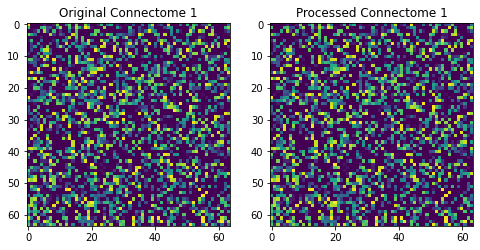

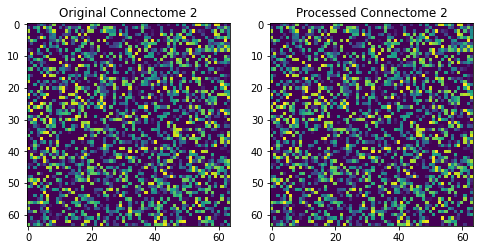

In [11]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Define the proc_connectomes function
def proc_connectomes(ls_connectomes, remove_negw=False, normalize=True):
    proc_ls = []

    for array in ls_connectomes:
        print("Array Shape After Reshape:", np.unique(array, return_counts=True))

        # Remove negative edges
        if remove_negw:
            array[array < 0] = 0
        print("Array Shape After Reshape:", np.unique(array, return_counts=True))

        # Reshape the array to 1D
        array_1d = array.reshape(-1)
        print("Array Shape After Reshape:", array.shape, np.unique(array_1d, return_counts=True))

        # Normalize the 1D array
        
        scaler = MinMaxScaler(feature_range=(array_1d.min(), array_1d.max()))
        print(array_1d.min(), array_1d.max())
        normalized_array_1d = scaler.fit_transform(array_1d.reshape(-1, 1))

        # Reshape the array back to its original shape
        array = normalized_array_1d.reshape(array.shape)
        print("Array Shape After Reshape:", array.shape, np.unique(array_1d, return_counts=True))

        # Set the main diagonal to 0
        np.fill_diagonal(array, 0)
        print(array.min(), array.max())
        proc_ls.append(array)

    return proc_ls

# Generate two random 64x64 arrays for testing
random_array1 = np.random.uniform(-1, 1, size=(64, 64))
random_array2 = np.random.uniform(-1, 1, size=(64, 64))
# Test the proc_connectomes function
input_connectomes = [random_array1, random_array2]
processed_connectomes = proc_connectomes(input_connectomes, remove_negw=True, normalize=True)

# Plot the original and processed connectomes
for i, connectome in enumerate(processed_connectomes):
    plt.figure(figsize=(8, 6))
    plt.subplot(121)
    plt.imshow(input_connectomes[i], cmap='viridis')
    plt.title(f'Original Connectome {i+1}')
    plt.subplot(122)
    plt.imshow(connectome, cmap='viridis')
    plt.title(f'Processed Connectome {i+1}')
    plt.show()


In [1]:
import networkx as nx
import community
import numpy as np
import os
import glob as glob
import pickle
import pandas as pd
from sklearn.model_selection import permutation_test_score
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit, GridSearchCV, KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.linear_model import RidgeCV
from statsmodels.stats.multitest import fdrcorrection


In [45]:
def compute_indiv_graphs_metrics(connectomes, subjects, labels):
    """
    Compute graph metrics for each subject's graph
    and return a list of feature matrices
    results : dict
    Y : dataframe, index = subject names and columns = target columns
    labels : list of strings from the atlas ROIs
    """
    metric_dict = dict(
        nodes=labels,
        degree=[],
        degreeCent=[],
        closenessCent=[],
        betweennessCent=[],
        clustering=[],
        communities=[],
    )
    # Initialize single-subject graphs from Adjacency matrix
    As = [connectomes[i] for i in range(len(connectomes))]
    rawGs = {nx.from_numpy_array(A, create_using=nx.Graph) for A in As}
    rawGs = {
        nx.relabel_nodes(G, dict(zip(range(len(G.nodes())), labels))) for G in rawGs
    }
    # add keys (subjects names) to make it a dict instead od a set
    Gs = dict()
    for name, G in zip(subjects, rawGs):
        Gs[name] = G
    # Adding a strengh attribute to each node
    for participant, graph in Gs.items():
        degree = graph.degree(weight="weight")
        strengths = {node: val for (node, val) in degree}  # Tuple to dict
        nx.set_node_attributes(graph, strengths, "strength")
        norm_strengths = {
            node: val * 1 / (len(graph.nodes) - 1) for (node, val) in degree
        }
        nx.set_node_attributes(graph, norm_strengths, "strengthnorm")
        metric_dict["degree"].append(list(dict(degree).values()))
    # Degree centrality
    for participant, G in Gs.items():
        degree = nx.degree_centrality(G)
        nx.set_node_attributes(G, degree, "degCentrality")
        metric_dict["degreeCent"].append(list(degree.values()))  # Save metric in a dict
    # betweenness centrality
    for participant, G in Gs.items():
        G_distance_dict = {
            (e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data="weight")
        }  # convert weight to distance to compute betweenness centrality
        nx.set_edge_attributes(G, G_distance_dict, "distance")
        betweenness = nx.betweenness_centrality(G, weight="distance")
        nx.set_node_attributes(G, betweenness, "betCentrality")
        metric_dict["betweennessCent"].append(list(betweenness.values()))
    # closeness centrality
    for participant, G in Gs.items():
        # G_distance_dict = {
        #    (e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data="weight")
        # }
        # nx.set_edge_attributes(G, G_distance_dict, "distance")
        closeness = nx.closeness_centrality(G, distance="distance")
        nx.set_node_attributes(G, closeness, "closecent")
        metric_dict["closenessCent"].append(list(closeness.values()))
    # clustering
    for participant, graph in Gs.items():
        clust = nx.clustering(graph, weight="weight")
        nx.set_node_attributes(graph, clust, "clustering")
        metric_dict["clustering"].append(list(clust.values()))
    # Communities
    for participant, graph in Gs.items():
        communities = nx.community.louvain_communities(graph) # Returns a list instead of a dict
        nx.set_node_attributes(graph, communities, "community")
        metric_dict["communities"].append(communities)

    # ---Feature matrices based on subjects' graphs---#
    participant_names = list(Gs.keys())
    node_names = list(Gs[participant_names[0]].nodes())
    
   # Reorganize data structure from lists of vectors to 
    for metric in list(metric_dict.keys())[1:-1]: #Excluding nodes and communities
        metric_dict[metric] = pd.DataFrame(np.array(metric_dict[metric]), columns=labels, index=subjects)

    return metric_dict




In [56]:
def connectome2feature_matrices(ls_connectomes, subjects, labels):
    '''
    Extracts half of the connectome matrix (lower triangular) and computes flattens it to stack it in array
    Connectomes : list of connectomes (adjacency matrices) for each subject
    return : array of shape (n_subjects, n_features)
    '''
    # Lower triangular mask
    tril_mask = np.tril(np.ones(ls_connectomes[0].shape[-2:]), k=-1).astype(bool)
    X_con = np.stack(
        [
            ls_connectomes[i][..., tril_mask]
            for i in range(0, len(ls_connectomes))
        ],
        axis=0,
    )  # store the original con matrix based on the flatten participants' features (shape : N x features)

    return pd.DataFrame(X_con, index=subjects)

In [46]:
ls1 = [np.random.uniform(0, 1, size=(10, 10)) for i in range(8)]
ls2 = [np.random.uniform(0, 1, size=(10,10)) for i in range(8)]
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
subjects = ['sub1', 'sub2', 'sub3', 'sub4', 'sub5', 'sub6', 'sub7', 'sub8']

ls1_dict = compute_indiv_graphs_metrics(ls1, subjects, labels)
ls2_dict = compute_indiv_graphs_metrics(ls2, subjects, labels)


<class 'list'> [{'h', 'c', 'd', 'f', 'b'}, {'e', 'g'}, {'i'}, {'a', 'j'}]
<class 'list'> [{'e'}, {'g'}, {'f', 'h'}, {'b', 'i', 'c'}, {'a', 'd', 'j'}]
<class 'list'> [{'a', 'c'}, {'b', 'i'}, {'j', 'h', 'd'}, {'e', 'g'}, {'f'}]
<class 'list'> [{'b', 'h', 'i'}, {'a', 'j', 'd'}, {'f', 'c'}, {'e', 'g'}]
<class 'list'> [{'a', 'g', 'b', 'd'}, {'j', 'h'}, {'e', 'c'}, {'f', 'i'}]
<class 'list'> [{'a', 'f', 'h'}, {'j', 'i', 'd'}, {'b', 'e', 'g', 'c'}]
<class 'list'> [{'a', 'i', 'j'}, {'f', 'c', 'd', 'e'}, {'b', 'g', 'h'}]
<class 'list'> [{'e', 'b', 'j'}, {'h', 'f', 'g', 'c'}, {'a', 'i', 'd'}]
<class 'list'> [{'a', 'c', 'i'}, {'d', 'e', 'g', 'j'}, {'b', 'f', 'h'}]
<class 'list'> [{'b', 'j', 'h'}, {'a', 'f', 'e'}, {'g', 'i', 'd', 'c'}]
<class 'list'> [{'a', 'd', 'i'}, {'e', 'b'}, {'f', 'g', 'c'}, {'h', 'j'}]
<class 'list'> [{'b', 'j'}, {'c'}, {'a', 'e'}, {'f'}, {'g', 'i'}, {'h', 'd'}]
<class 'list'> [{'c'}, {'b', 'i'}, {'a', 'j', 'd'}, {'f', 'g', 'h', 'e'}]
<class 'list'> [{'a', 'h', 'i'}, {'e', '

In [57]:
X = connectome2feature_matrices(ls1, subjects, labels)

In [58]:
X.shape

(8, 45)

In [47]:
for metric in list(ls1_dict.keys())[1:-1]:
    print(metric, ls1_dict[metric].shape, ls2_dict[metric].shape)

degree (8, 10) (8, 10)
degreeCent (8, 10) (8, 10)
closenessCent (8, 10) (8, 10)
betweennessCent (8, 10) (8, 10)
clustering (8, 10) (8, 10)


In [48]:
def metrics_diff_postpre(post_dict, pre_dict, subjects):

    assert post_dict.keys() == pre_dict.keys()
    metric_keys = list(post_dict.keys())[1:-1] # removing the 'nodes' and 'communities' keys 
    change_dict = {}

    for metric in metric_keys:
        postpre_diff = post_dict[metric] - pre_dict[metric]
        df = pd.DataFrame(postpre_diff, columns=post_dict['nodes'], index=subjects)
        change_dict[metric] = df
    
    return change_dict
change_dict = metrics_diff_postpre(ls2_dict, ls1_dict, subjects)

In [49]:
change_dict

{'degree':              a         b         c         d         e         f         g  \
 sub1  1.943180  0.222589 -0.587249 -1.362713  0.171619 -1.720211 -1.713611   
 sub2 -2.623432 -2.086090  0.699372  0.565648 -0.845165 -0.545654  0.108582   
 sub3  1.443731  2.554280  0.878341  3.368706 -0.343751 -1.401764  2.280951   
 sub4  0.699986 -0.094318 -0.243180  3.214662 -0.038315  0.452530 -2.142400   
 sub5  3.370607  2.385322  1.843884 -1.089136 -0.121737 -2.912554  0.505189   
 sub6  3.645613  1.365833 -0.422753 -2.676795  1.132958 -0.941046  0.015702   
 sub7  1.733910 -3.156880  0.592028 -1.678844  0.666242 -0.588628 -2.797834   
 sub8  2.916479 -0.893329  0.287749 -1.973003 -0.234902  0.755405 -0.467981   
 
              h         i         j  
 sub1 -1.416113  2.298709  2.219821  
 sub2  2.026614  0.657866 -1.156513  
 sub3  1.781542  0.163482 -1.484942  
 sub4 -1.637505 -1.506367 -0.200022  
 sub5  0.214535 -0.051917  0.066311  
 sub6 -0.009858 -0.665843  5.540751  
 sub7 -0.25